In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from claw import *
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # lower dpi for faster plotting 
savefig = False # set false for faster plotting

In [3]:
np.random.seed(2)

# Claw

Visualizing the worst case metric graph $G$, also called a *claw*, that is a complete bipartite graph

\begin{equation}
G = K_{1, 3}
\end{equation}

embedded in $\mathbb{R}^{2}$ in such a way it is hard to distinguish two edges because they are to close in the embedding space; see (Lecci et al., 2014):

[https://jmlr.csail.mit.edu/papers/volume15/lecci14a/lecci14a.pdf](https://jmlr.csail.mit.edu/papers/volume15/lecci14a/lecci14a.pdf)

Section 3.1.

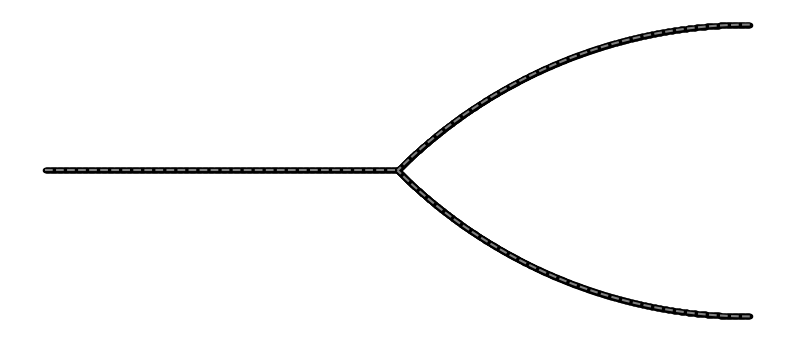

In [4]:
claw = Claw()
claw.plot_claw(savefig=savefig)

## Construction

We construct $G$ by gluing together 3 curves:

* line segment $a x$ of length 1;
* two arcs $e_{1} = x t_{1}$, $e_{2} = x t_{2}$ enclosing the angle $\theta$ from two circles with radius $\tau$ of lengths $\theta \tau$.

To represent $G$, we sample: 

* $n$ points from the interior of the line segment $a x$ 

* proportionally to the arcs lengths more points from interiour of each arc $e_{1}, e_{2}$:

$$
\lfloor \theta \tau n \rfloor
$$

* and add 3 boundary points and one point of intersection to the sample.

For 
\begin{align*}
\theta &= \frac{\pi}{4} \\
\tau &= \sqrt{2}
\end{align*}

the length of arcs are:

In [5]:
np.pi/4 * np.sqrt(2)

1.1107207345395915

And for $n = 10$ points in the line segment $a x$ represented in blue in the figure below, we have 

In [6]:
n = 10
int(np.floor(np.pi/4 * np.sqrt(2) * n))

11

points for each arc, represented in green and red. Boundary points and point of intersection are represented in black.

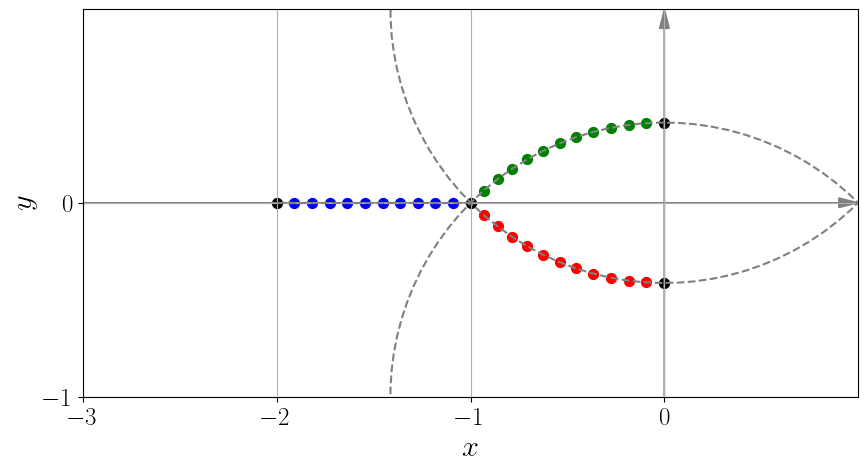

In [7]:
claw = Claw(n=10)
claw.plot_parts(plot_construction=True, savefig=savefig)

## Sampling

**Definition.** A sample $Y = \lbrace y_{k} \rbrace_{k=1}^{n} \subset G$ is $\frac{\delta}{2}$*-dense* in $G$ if for each $x \in G$ there exists $y \in Y$ such that 
$$
\left\lVert x - y \right\rVert_{2} < \frac{\delta}{2}
$$

In other words, if the union of open balls of radius $\frac{\delta}{2}$ around $y_{k}, k = 1, ..., n$, cover $G$.

For $\delta=0.2$. Sample of $n=10$ points that is not $\frac{\delta}{2}$-dense in $G$:

False


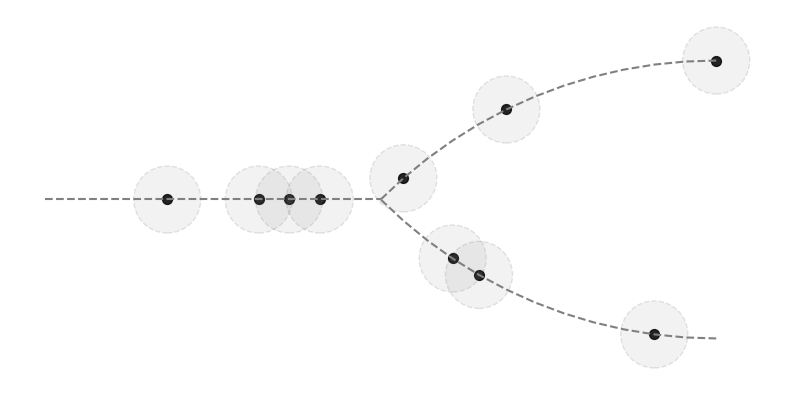

In [8]:
delta = 0.2

sample_points = claw.get_sample_points(10)
print(claw.is_dense(sample_points, delta))
claw.plot_sample(sample_points, delta, savefig=savefig)

Sample of $n=100$ points that is $\frac{\delta}{2}$-dense in $G$:

True


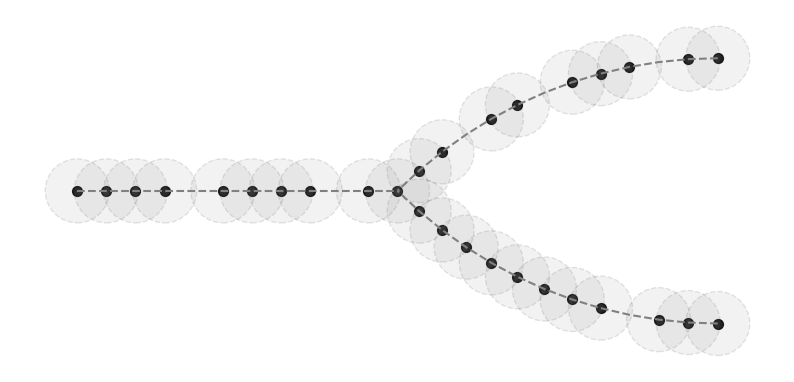

In [9]:
sample_points = claw.get_sample_points(30)
print(claw.is_dense(sample_points, delta))
claw.plot_sample(sample_points, delta, savefig=savefig)